# Lab13 Q-Learning in the Grid-World

[Adapted from Jeremy Zhang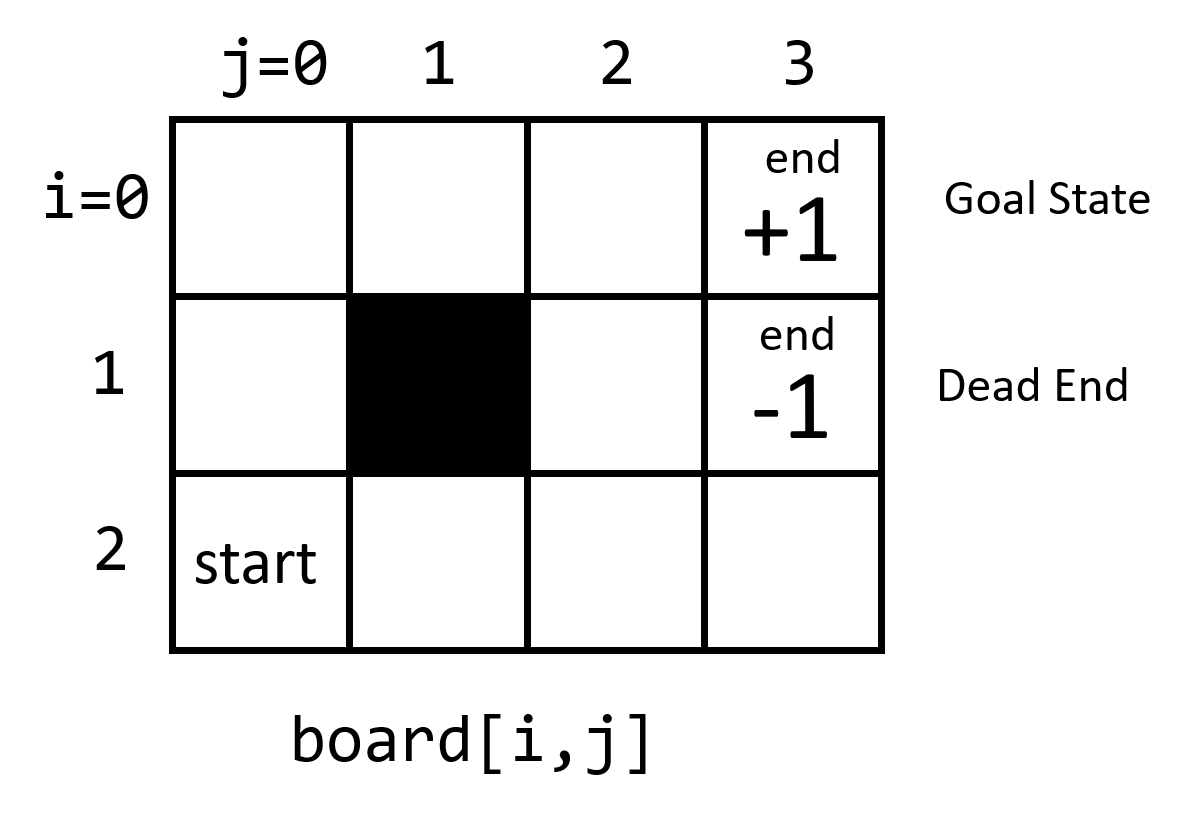](https://towardsdatascience.com/implement-grid-world-with-q-learning-51151747b455)

Gridworld is the most basic as well as classic problem in reinforcement learning and by looking into its implementation (or trying to implement it yourself) is the best way to understand the basis of reinforcement learning.

The board is depicted in the image above and the rules are simple:

- Your agent/robot starts at the left-bottom corner(the ‘start’ sign) and ends at either +1 or -1 which is the corresponding reward.
- At each step, the agent has 4 possible actions including up, down, left and right, whereas the black block is a wall where your agent won’t be able to penetrate through.
- If the agent hits the wall, it will remain at the same position.

The $Q$ function — $Q(s, a)$ is the expected return when starting from state $s$ and taking action $a$. It specifies the goodness of an action in a state.
This means that when we have obtained the optimal Q-function, we know the optimal action at each state (the one with the max expected return).

Note also that:
- The agent action is **non-deterministic**, i.e. we have a stochastic environment with a transition probability $P_{ss'}$ from one state $s$ to another state $s'$
- Reward discount is $\gamma \in [0,1]$

Non-deterministic means that the environment is stochastic and the agent will not be able to go where it intends to go. When it takes an action, it will have a probability to end up doing a different action. For example, when the agent selects the action to move up, it has 0.8 probability moving up and 0.1 probability of going left or right.



## Q-learning algorithm


One of the early breakthroughs in reinforcement learning was the development of an
off-policy TD control algorithm known as Q-learning (Watkins, 1989), defined by

$$ Q(s_t,a_t) \leftarrow Q(s_t,a_t)+ \alpha \cdot \left[ R_{t+1}+ \gamma \max_a Q(s_{t+1},a)-Q(s_t,a_t)\right]$$

- In this case, the learned action-value function, $Q$, directly approximates $Q^*$, the optimal action-value function, *independent of the policy being followed*. This dramatically simplifies the analysis of the algorithm and enabled early convergence proofs. The policy still has an effect in that it determines which state–action pairs are visited and updated. The policy can directly be derived from $Q$, e.g. using an $\varepsilon$-greedy approach.
- However, all that is required for correct convergence is that all pairs continue to be updated. Under this assumption and a variant of the usual stochastic approximation conditions on the sequence of step-size parameters, $Q$ has been shown to converge with probability $1$ to $Q^*$. The Q-learning algorithm is shown below in procedural form.



The *Q-learning-algorithm* is intrinsically **off-policy**, since it does not draw samples from a given policy $\pi$.

1. **Perform an action** $a$ in a state $s$ to end up in $s'$ with reward $r$, i.e. consider the tuple $(s,a,s',r)$
2. **Compute the intermediate Q-value:**
$$ \hat{Q}(s,a)=R(s,a,s')+\gamma \max_{a'} Q_k(s',a')$$

3. Incorporate that new evidence into the existing value using an **update rule** ($\alpha$ is the learning rate):
$$ Q_{k+1}(s,a) = Q_k(s,a)+\alpha \cdot \left( \hat{Q}(s,a)-Q_k(s,a) \right)$$



In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
BOARD_ROWS = 3
BOARD_COLS = 4
WIN_STATE = (0, BOARD_ROWS)
LOSE_STATE = (1, BOARD_ROWS)
START = (2, 0)
DETERMINISTIC = False
DO_PRINT = False

When the agent takes an action, the `Environment` should have a function to accept an action and return a legal position of next state.

In [26]:
class Environment:
    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[1, 1] = -1
        self.state = state
        self.isEnd = False
        self.determine = DETERMINISTIC

    def giveReward(self):
        if self.state == WIN_STATE:
            return 1
        elif self.state == LOSE_STATE:
            return -1
        else:
            return 0

    def isEndFunc(self):
        if (self.state == WIN_STATE) or (self.state == LOSE_STATE):
            self.isEnd = True

    def _chooseActionProb(self, action):
        if action == "up":
            return np.random.choice(["up", "left", "right"], p=[0.8, 0.1, 0.1])
        if action == "down":
            return np.random.choice(["down", "left", "right"], p=[0.8, 0.1, 0.1])
        if action == "left":
            return np.random.choice(["left", "up", "down"], p=[0.8, 0.1, 0.1])
        if action == "right":
            return np.random.choice(["right", "up", "down"], p=[0.8, 0.1, 0.1])

    def nxtPosition(self, action):
        """
        action: up, down, left, right
        -------------
        0 | 1 | 2| 3|
        1 |
        2 |
        return next position on board
        """
        if self.determine:
            if action == "up":
                nxtState = (self.state[0]-1, self.state[1])
            elif action == "down":
                nxtState = (self.state[0]+1, self.state[1])
            elif action == "left":
                nxtState = (self.state[0], self.state[1]-1)
            else:
                nxtState = (self.state[0], self.state[1]+1)
            self.determine = False
        else:
            # non-deterministic
            action = self._chooseActionProb(action)
            self.determine = True
            nxtState = self.nxtPosition(action)

        # if next state is legal
        if (nxtState[0] >= 0) and (nxtState[0] <= BOARD_ROWS-1):
            if (nxtState[1] >= 0) and (nxtState[1] <= BOARD_COLS-1):
                if nxtState != (1, 1):
                    return nxtState
        return self.state

    def showBoard(self):
        self.board[self.state] = 1
        for i in range(0, BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = '*'
                if self.board[i, j] == -1:
                    token = 'z'
                if self.board[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-----------------')

### Temporal Difference Learning

- Firstly, at each step, an agent takes action $a$ , collecting corresponding reward $r$ , and moves from state $s$ to $s'$. So a whole pair of $(s, a, s',r)$ is considered at each step.
- Secondly, we give an estimation of current $Q$ value, which equals to current reward plus maximum $Q$ value of next state times a decay rate $\gamma$. One thing worth noting is that we set all intermediate reward as 0, so the agent won’t be able to collect any non-zero reward until the end state, either 1 or -1.(This is not compulsory, you can try out other reward and see how the agent acts)
- Lastly, we update the estimation of the current Q value by adding $\alpha$ times a **temporal difference** (which is the difference between new estimation and current value).

### Action
- In terms of action taking, it will still be based on exploration rate.
- When the agent exploits the state, **it will take the action that maximises the Q value according to current estimation of Q-value**.



In [27]:
class Agent:

    def __init__(self):
        self.states = []  # record position and action taken at the position
        self.actions = ["up", "down", "left", "right"]
        self.State = Environment()
        self.isEnd = self.State.isEnd
        self.lr = 0.2
        self.exp_rate = 0.3
        self.decay_gamma = 0.9

        #initialize the value function
        # V_values is a list
        self.state_values = {}

        #initial policy
        self.policy={}

        # initial Q values
        self.Q_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.state_values[(i,j)]=0
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0  # Q value is a dict of dict

    def chooseAction(self):
        # choose action with most expected value
        mx_nxt_reward = 0
        action = ""

        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            for a in self.actions:
                current_position = self.State.state
                nxt_reward = self.Q_values[current_position][a]
                if nxt_reward >= mx_nxt_reward:
                    action = a
                    mx_nxt_reward = nxt_reward
            #print("current pos: {}, greedy aciton: {}".format(self.State.state, action))
        return action

    def takeAction(self, action):
        position = self.State.nxtPosition(action)
        # update State
        return Environment(state=position)

    def reset(self):
        self.states = []
        self.State = Environment()
        self.isEnd = self.State.isEnd

    def play(self, rounds=10):
        i = 0
        while i < rounds:
            # to the end of game back propagate reward
            if self.State.isEnd:
                # back propagate
                reward = self.State.giveReward()
                for a in self.actions:
                    self.Q_values[self.State.state][a] = reward
                if DO_PRINT:
                    print("Game End Reward", reward)
                for s in reversed(self.states):
                    current_q_value = self.Q_values[s[0]][s[1]]
                    reward = current_q_value + self.lr*(self.decay_gamma*reward - current_q_value)
                    self.Q_values[s[0]][s[1]] = round(reward, 3)
                self.reset()
                i += 1
            else:
                action = self.chooseAction()
                # append trace
                self.states.append([(self.State.state), action])
                if DO_PRINT:
                    print("current position {} action {}".format(self.State.state, action))
                # by taking the action, it reaches the next state
                self.State = self.takeAction(action)
                # mark is end
                self.State.isEndFunc()
                if DO_PRINT:
                    print("nxt state", self.State.state)
                    print("---------------------")
                self.isEnd = self.State.isEnd

    # calculate the value function V*(s) and the optimum policy pi*
    def CalcValueFunction(self):
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                Q=np.zeros(4)
                for k,a in enumerate(self.actions):
                    Q[k]=self.Q_values[(i, j)][a]

                #following the optimum policy
                self.policy[(i,j)]=np.argmax(Q)
                self.state_values[(i,j)]=self.state_values[(i,j)]+np.max(Q)

    # display the value function V*(s)
    def showValues(self):
        self.CalcValueFunction()
        for i in range(0, BOARD_ROWS):
            print('-----------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                out += "%+1.3f |" % self.state_values[(i, j)]
            print(out)
        print('-----------------------------------')

    # display the optimum policy pi*(s)
    def showPolicy(self):
        self.CalcValueFunction()
        for i in range(0, BOARD_ROWS):
            print('-----------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                myPolicy=self.actions[self.policy[(i,j)]]
                if myPolicy=='up':
                    direction=' ^  '
                if myPolicy=='down':
                    direction=' v  '
                if myPolicy=='left':
                    direction=' <--'
                if myPolicy=='right':
                    direction=' -->'

                out += "%s\t|" % direction
            print(out)
        print('-----------------------------------')



In [28]:
ag = Agent()
ag.reset()

In [29]:
ag.Q_values

{(0, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (0, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (0, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (0, 3): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (1, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (1, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (1, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (1, 3): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (2, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (2, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (2, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (2, 3): {'up': 0, 'down': 0, 'left': 0, 'right': 0}}

In [30]:
ag.play(100)

In [31]:
ag.Q_values

{(0, 0): {'up': 0.325, 'down': 0.254, 'left': 0.289, 'right': 0.521},
 (0, 1): {'up': 0.397, 'down': 0.438, 'left': 0.384, 'right': 0.723},
 (0, 2): {'up': 0.492, 'down': 0.172, 'left': 0.394, 'right': 0.859},
 (0, 3): {'up': 1, 'down': 1, 'left': 1, 'right': 1},
 (1, 0): {'up': 0.404, 'down': 0.225, 'left': 0.281, 'right': 0.283},
 (1, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 (1, 2): {'up': 0.658, 'down': 0.043, 'left': 0.163, 'right': -0.21},
 (1, 3): {'up': -1, 'down': -1, 'left': -1, 'right': -1},
 (2, 0): {'up': 0.277, 'down': 0.191, 'left': 0.238, 'right': 0.099},
 (2, 1): {'up': 0.002, 'down': 0.046, 'left': 0.224, 'right': 0.011},
 (2, 2): {'up': 0.252, 'down': -0.058, 'left': 0.0, 'right': -0.032},
 (2, 3): {'up': -0.324, 'down': 0, 'left': 0, 'right': 0}}

In [32]:
ag.showValues()

-----------------------------------
| +0.521 |+0.723 |+0.859 |+1.000 |
-----------------------------------
| +0.404 |+0.000 |+0.658 |-1.000 |
-----------------------------------
| +0.277 |+0.224 |+0.252 |+0.000 |
-----------------------------------


In [33]:
ag.state_values

{(0, 0): 0.521,
 (0, 1): 0.723,
 (0, 2): 0.859,
 (0, 3): 1.0,
 (1, 0): 0.404,
 (1, 1): 0.0,
 (1, 2): 0.658,
 (1, 3): -1.0,
 (2, 0): 0.277,
 (2, 1): 0.224,
 (2, 2): 0.252,
 (2, 3): 0.0}

In [34]:
ag.showPolicy()

-----------------------------------
|  -->	| -->	| -->	| ^  	|
-----------------------------------
|  ^  	| ^  	| ^  	| ^  	|
-----------------------------------
|  ^  	| <--	| ^  	| v  	|
-----------------------------------
